In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import mysql.connector as mysqlpy
import os
from pathlib import Path

## Chargement des datas

In [2]:
def get_db_connection():
    user = os.environ.get('DB_USER')
    password = os.environ.get('DB_PASSWORD')
    host = os.environ.get('DB_HOST')
    port = os.environ.get('DB_PORT')
    database = os.environ.get('DB_DATABASE')
    bdd = mysqlpy.connect(user=user, password=password, host=host, port=port, database=database)
    return bdd

bdd = get_db_connection()
cursor = bdd.cursor()
cursor.execute(f'''SELECT *, patients.name AS name_patient, anatomopathologists.name AS name_med FROM CRO 
               JOIN patients USING (nir) 
               JOIN diagnostics USING (id_diag) 
               JOIN anatomopathologists  USING (id_med);''')
CRO = cursor.fetchall()

columns=[i[0] for i in cursor.description]

CRO = pd.DataFrame(CRO, columns= columns)
CRO = CRO.drop(['name'], axis = 1)

cursor.execute(f'''SELECT * FROM diagnostics;''')
diag = cursor.fetchall()

columns=[i[0] for i in cursor.description]

diag = pd.DataFrame(diag, columns= columns)

cursor.close()

True

In [3]:
CRO.head(5)

,id_med,id_diag,nir,CRO,source,operation,address,birthday,organe,diagnostic,cancer,name_patient,name_med
0,13,35,1 1963 01 21813 466 38,Compte Rendu d'Histopathologie - Biopsie de Cô...,codellama/CodeLlama-34b-Instruct-hf,biopsie,"49, boulevard de Jacques, 21813 Legendre",15/01/1963,côlon,colite ulcéreuse,0,Gilbert Étienne,Dr François Andre
1,18,38,1 1963 01 21813 466 38,COMPTÉ RENDU D'HISTOPATHOLOGIE\n\nPatient:\nNo...,chatGPT3.5,colectomie,"49, boulevard de Jacques, 21813 Legendre",15/01/1963,côlon,colite ischémique,0,Gilbert Étienne,Dr Isaac Bazin
2,18,18,1 1963 01 21813 466 38,Compte-rendu d'histopathologie\n\nPatient :\n-...,chatGPT3.5,biopsie,"49, boulevard de Jacques, 21813 Legendre",15/01/1963,peau,eczéma nummulaire,0,Gilbert Étienne,Dr Isaac Bazin
3,1,32,1 1963 01 21813 466 38,Compte rendu d'histopathologie\n\nPatient:\nNo...,chatGPT3.5,exérèse,"49, boulevard de Jacques, 21813 Legendre",15/01/1963,peau,carcinome basosquameux,0,Gilbert Étienne,Dr Olivier Bernier
4,13,36,1 1960 11 65552 524 96,Compte-Rendu d'Histopathologie\n\nPatient :\nN...,chatGPT3.5,biopsie,"avenue Georges David, 65552 Saint Simone",04/11/1960,côlon,colite indéterminée,0,Joseph Berthelot,Dr François Andre


In [4]:
diag.head(5)

,organe,diagnostic,cancer,id_diag
0,peau,psoriasis,0,0
1,peau,dermatite atopique,0,1
2,peau,lupus érythémateux,0,2
3,peau,dermatite herpétiforme,0,3
4,peau,lichen plan,0,4


In [5]:
CRO_train_valid = CRO.query('organe != "foie"').reset_index(drop=True)
CRO_test = CRO.query('organe == "foie"').reset_index(drop=True)

CRO_train, CRO_valid = train_test_split(CRO_train_valid, test_size=0.2, stratify=CRO_train_valid['id_diag'], random_state=42)
CRO_train= CRO_train.reset_index(drop=True)
CRO_valid = CRO_valid.reset_index(drop=True)

In [6]:
print(f'Dans le dataset primaire, il y a {len(CRO)} CRO.')
print(f'Dans le dataset train, il y a {len(CRO_train)} CRO.')
print(f'Dans le dataset valid, il y a {len(CRO_valid)} CRO.')
print(f'Dans le datasset test, il y a {len(CRO_test)} CRO.')

Dans le dataset primaire, il y a 2091 CRO.
Dans le dataset train, il y a 1492 CRO.
Dans le dataset valid, il y a 373 CRO.
Dans le datasset test, il y a 226 CRO.


# Data augmentation

In [7]:
def data_aug_CRO(CRO: pd.DataFrame, diag_inf_ref: dict, diag: pd.DataFrame, ref) -> list:
    '''
    Data augmentation en remplaçant le diagnostic dans un autre CRO, mais en conservant les autres données
    entrée:
        -CRO : df contenant tous les CRO
        -diag_inf_ref : dict des diagnostics à augmenter
        -diag : df de diagnostics pour récupérer l'id_diag
        -ref : nb de CRO qui doit être généré par class de diagnostic du CRO
    '''
    new_CRO_list = []
    for value, key in diag_inf_ref.items():
        nb_diag = len(CRO.query(f'diagnostic == "{value}"'))
        diag_value = diag.query(f'diagnostic == "{value}"')
        print(diag_value.id_diag)
        while nb_diag < ref:
            random_CRO = random.randint(0, len(CRO) - 1)
            new_CRO = CRO.CRO[random_CRO].replace(CRO.diagnostic[random_CRO].lower(), value.lower())
            new_CRO_list.append({'CRO': new_CRO,  'source': CRO.source[random_CRO], 'operation': CRO.operation[random_CRO],
                                 'nir': CRO.nir[random_CRO], 'name_patient': CRO.name_patient[random_CRO], 'address': CRO.address[random_CRO], 'birthday': CRO.birthday[random_CRO],
                                 'id_med': CRO.id_med[random_CRO], 'name_med': CRO.name_med[random_CRO],
                                 'id_diag': diag_value.id_diag.tolist()[0], 'diagnostic': diag_value.diagnostic.tolist()[0], 'organe': diag_value.organe.tolist()[0], 'cancer': diag_value.cancer.tolist()[0],   
                                })
            nb_diag += 1
            print('nb_diag', nb_diag, value)
    return new_CRO_list

In [8]:
nb_diag_train = 10
nb_diag_valid = nb_diag_train // 4 if nb_diag_train // 4 != 0 else 1
nb_diag_test = 10

print(nb_diag_train, nb_diag_valid, nb_diag_test)

10 2 10


## CRO Train

Text(0, 0.5, 'Occurence')

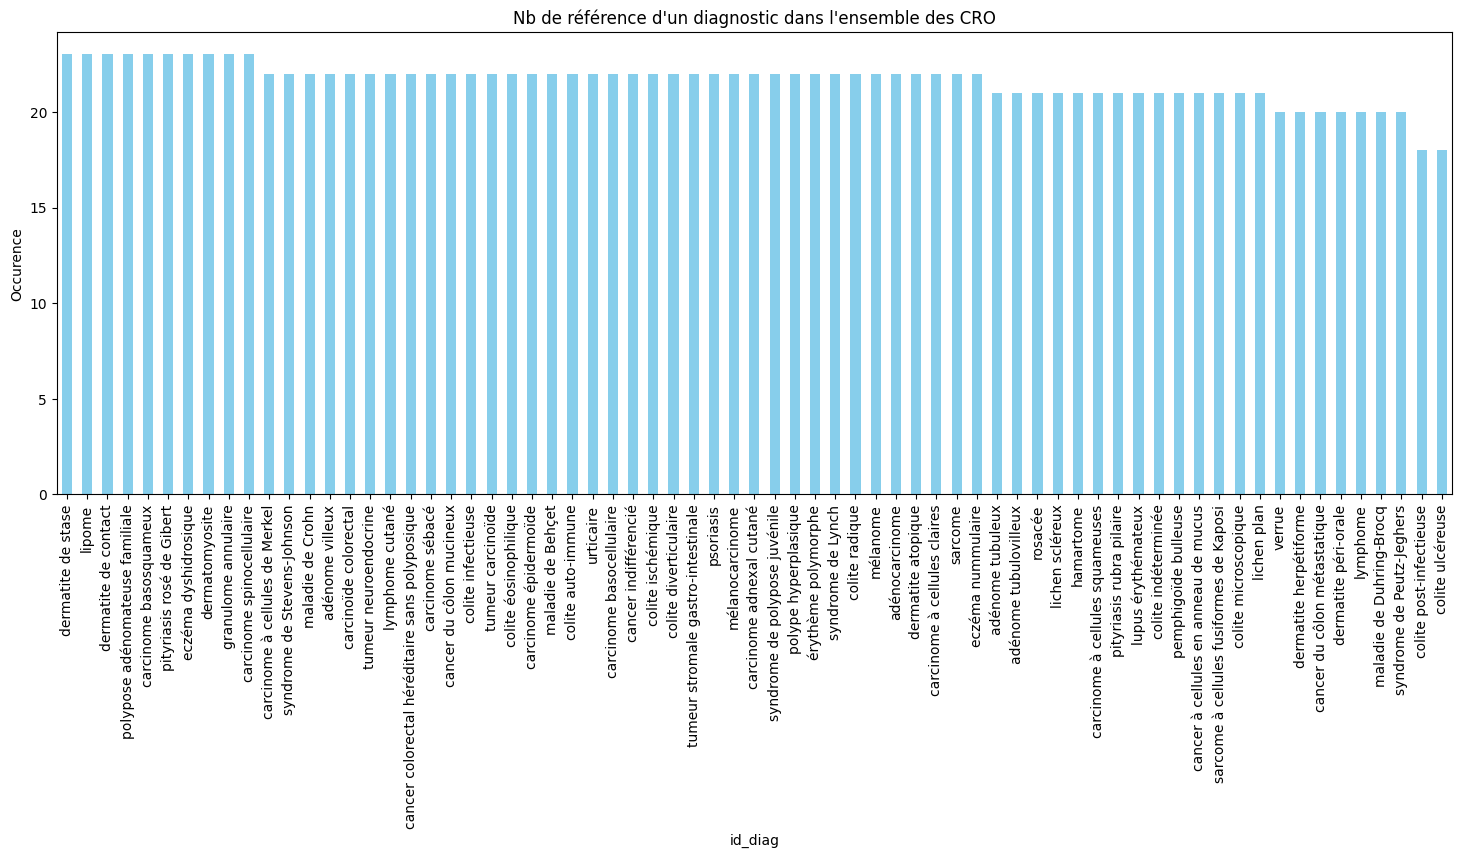

In [9]:
value_counts_train = CRO_train['diagnostic'].value_counts()

plt.figure(figsize=(18, 6))
value_counts_train.plot(kind='bar', color='skyblue')
plt.title("Nb de référence d'un diagnostic dans l'ensemble des CRO")
plt.xlabel('id_diag')
plt.ylabel('Occurence')

In [10]:
# diagnostics qui doivent être augmentés

diagnostics_nb = dict(value_counts_train)
ref = nb_diag_train
# Utilisation d'une compréhension de dictionnaire pour filtrer les clés
diag_inf_train_ref = {cle: valeur for cle, valeur in diagnostics_nb.items() if valeur < ref}
for key, value in diag_inf_train_ref.items():
    print(key, ':', value)

In [11]:
print(f'nb de diag inf à {ref} :', len(diag_inf_train_ref.keys()))

nb de diag inf à 10 : 0


In [12]:
# data augmentation du train si nécessaire

new_CRO_train_list = data_aug_CRO(CRO_train, diag_inf_train_ref, diag, ref)

In [13]:
new_CRO_train = pd.DataFrame(new_CRO_train_list)
new_CRO_train.head()

""


In [14]:
# affichage des diag augmentés

try: 
    value_counts_bis = new_CRO_train['diagnostic'].value_counts()

    plt.figure(figsize=(18, 6))
    value_counts_bis.plot(kind='bar', color='skyblue')
    plt.title("Nb de référence d'un diagnostic dans l'ensemble des CRO")
    plt.xlabel('id_diag')
    plt.ylabel('Occurence')
except:
    new_CRO_train = new_CRO_train

In [15]:
#  ajout des nouveaux CRO aux anciens

CRO_train_fusion = pd.concat([CRO_train, new_CRO_train], ignore_index=True)
CRO_train_fusion.head()

,id_med,id_diag,nir,CRO,source,operation,address,birthday,organe,diagnostic,cancer,name_patient,name_med
0,52,38,2 1980 10 97375 990 10,Compte Rendu d'Histopathologie - coloscopie av...,codellama/CodeLlama-34b-Instruct-hf,colectomie,"rue Louis Colin, 97375 Texier-sur-Delmas",23/10/1980,côlon,colite ischémique,0,Susan Rémy,Dr Renée Guichard
1,22,58,2 1951 09 24163 333 42,Compte Rendu d'Histopathologie\nNom de l'anato...,codellama/CodeLlama-34b-Instruct-hf,biopsie,"23, rue de Pineau, 24163 Sainte Adélaïdeboeuf",25/09/1951,côlon,tumeur neuroendocrine,1,Océane Vaillant,Dr Marcel Lemaire
2,12,57,2 2001 07 87283 983 57,Compte Rendu d'Histopathologie\nDr Patrick Cle...,codellama/CodeLlama-34b-Instruct-hf,biopsie,"8, chemin de Bernard, 87283 Sainte Valentineboeuf",14/07/2001,côlon,sarcome,1,Amélie Dubois,Dr Patrick Clerc
3,11,67,2 1959 03 03584 218 58,Compte Rendu d'Histopathologie\nNom de l'anato...,codellama/CodeLlama-34b-Instruct-hf,biopsie,"16, rue Marianne Hubert, 03584 Muller",07/03/1959,côlon,hamartome,0,Christiane Bouvet,Dr Arthur Dubois
4,72,60,2 1951 04 39134 461 39,Compte Rendu d'Histopathologie\nDr Geneviève D...,codellama/CodeLlama-34b-Instruct-hf,colectomie,"90, rue de Charles, 39134 NguyenVille",04/04/1951,côlon,tumeur stromale gastro-intestinale,1,Danielle Mallet,Dr Geneviève Descamps


In [16]:
print(len(new_CRO_train))
print(len(CRO_train))
print(len(new_CRO_train) + len(CRO_train))
print(len(CRO_train_fusion))

0
1492
1492
1492


Text(0, 0.5, 'Occurence')

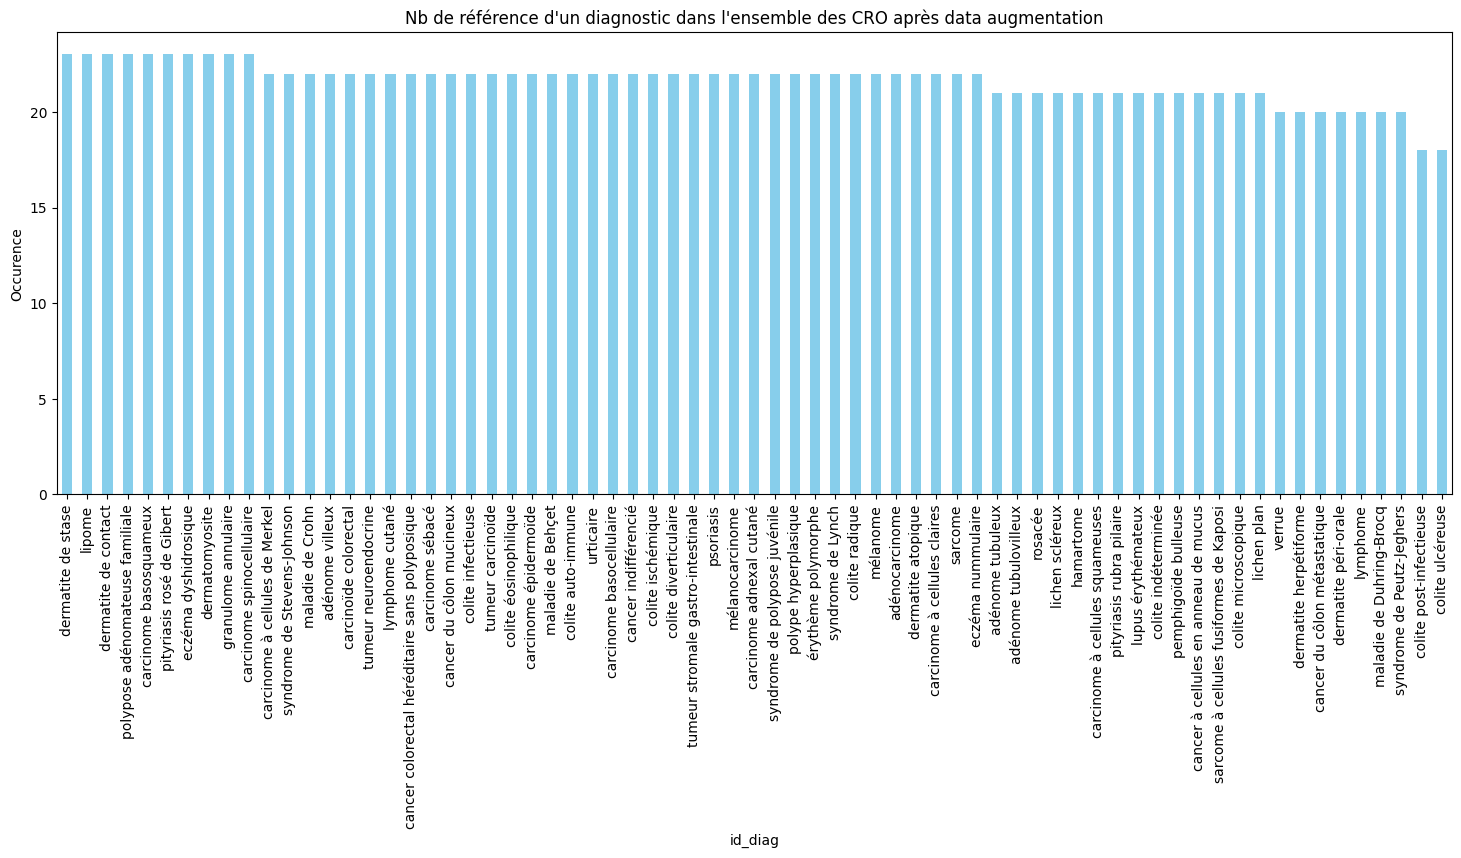

In [17]:
value_counts_bis_bis = CRO_train_fusion['diagnostic'].value_counts()

plt.figure(figsize=(18, 6))
value_counts_bis_bis.plot(kind='bar', color='skyblue')
plt.title("Nb de référence d'un diagnostic dans l'ensemble des CRO après data augmentation")
plt.xlabel('id_diag')
plt.ylabel('Occurence')

In [18]:
# Mise à niveau du dataframe pour correspondre à la limite sélectionnée par diag

nb_lignes_par_classe = ref
grouped_CRO_train = CRO_train_fusion.groupby('diagnostic', group_keys=False)
CRO_train_eq = grouped_CRO_train.apply(lambda x: x.sample(nb_lignes_par_classe, random_state=42))
CRO_train_eq = CRO_train_eq.reset_index(drop=True)

print('avant mise à niveau:',len(CRO_train_fusion))
print('après mise à niveau:',len(CRO_train_eq))

avant mise à niveau: 1492
après mise à niveau: 690


In [19]:
print(CRO_train_eq['diagnostic'].value_counts())

diagnostic
adénocarcinome            10
lymphome cutané           10
pemphigoïde bulleuse      10
mélanome                  10
mélanocarcinome           10
                          ..
dermatite atopique        10
dermatite de contact      10
dermatite de stase        10
dermatite herpétiforme    10
érythème polymorphe       10
Name: count, Length: 69, dtype: int64


## CRO Valid

Text(0, 0.5, 'Occurence')

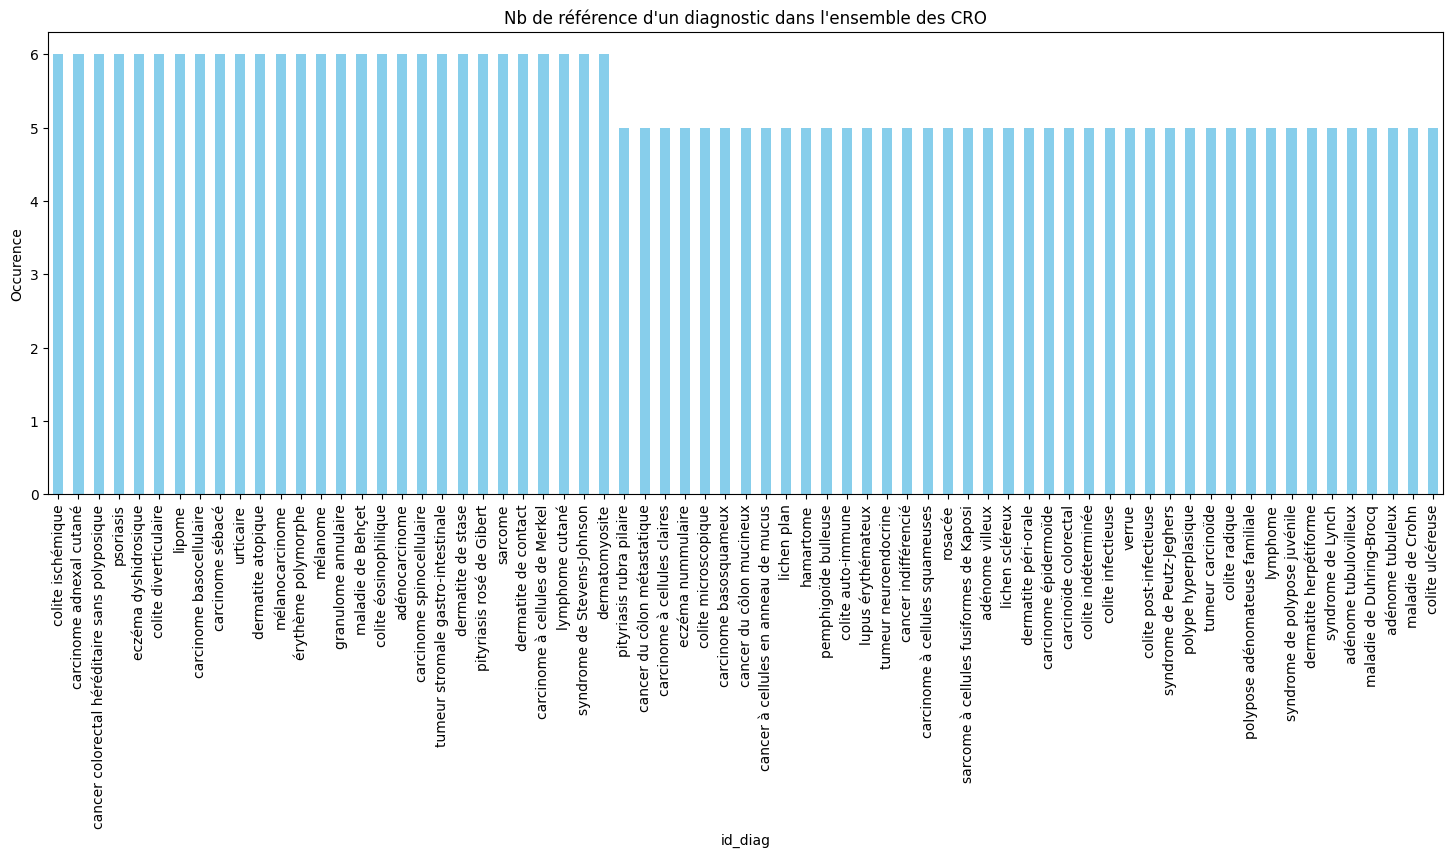

In [20]:
value_counts_valid = CRO_valid['diagnostic'].value_counts()

plt.figure(figsize=(18, 6))
value_counts_valid.plot(kind='bar', color='skyblue')
plt.title("Nb de référence d'un diagnostic dans l'ensemble des CRO")
plt.xlabel('id_diag')
plt.ylabel('Occurence')

In [21]:
# diagnostics qui doivent être augmentés

diagnostics_nb = dict(value_counts_valid)
ref = nb_diag_valid
# Utilisation d'une compréhension de dictionnaire pour filtrer les clés
diag_inf_valid_ref = {cle: valeur for cle, valeur in diagnostics_nb.items() if valeur < ref}
for key, value in diag_inf_valid_ref.items():
    print(key, ':', value)

In [22]:
print(f'nb de diag inf à {ref} :', len(diag_inf_valid_ref.keys()))

nb de diag inf à 2 : 0


In [23]:
# data augmentation du train si nécessaire

new_CRO_valid_list = data_aug_CRO(CRO_valid, diag_inf_valid_ref, diag, ref)

In [24]:
new_CRO_valid = pd.DataFrame(new_CRO_valid_list)
new_CRO_valid.head()

""


In [25]:
# affichage des diag augmentés

try:
    value_counts_bis = new_CRO_valid['diagnostic'].value_counts()

    plt.figure(figsize=(18, 6))
    value_counts_bis.plot(kind='bar', color='skyblue')
    plt.title("Nb de référence d'un diagnostic dans l'ensemble des CRO")
    plt.xlabel('id_diag')
    plt.ylabel('Occurence')
except:
    new_CRO_valid = new_CRO_valid

In [26]:
#  ajout des nouveaux CRO aux anciens

CRO_valid_fusion = pd.concat((CRO_valid, new_CRO_valid), ignore_index=True)
CRO_valid_fusion.head(5)

,id_med,id_diag,nir,CRO,source,operation,address,birthday,organe,diagnostic,cancer,name_patient,name_med
0,9,38,2 1951 04 39134 461 39,Compte Rendu d'Histopathologie - coloscopie av...,codellama/CodeLlama-34b-Instruct-hf,colectomie,"90, rue de Charles, 39134 NguyenVille",04/04/1951,côlon,colite ischémique,0,Danielle Mallet,Dr Alexandre Da Costa
1,2,49,1 1998 03 74510 756 57,Compte Rendu d'Histopathologie - Colectomie de...,codellama/CodeLlama-34b-Instruct-hf,colectomie,"3, boulevard Simon, 74510 Devaux",17/03/1998,côlon,polypose adénomateuse familiale,1,Alexandre Clément,Dr Antoine Brunet
2,67,62,2 1938 11 14740 159 39,Compte Rendu d'Histopathologie - Biopsie de Cô...,codellama/CodeLlama-34b-Instruct-hf,biopsie,"76, chemin Georges Raymond, 14740 Marty-les-Bains",16/11/1938,côlon,adénome villeux,1,Sabine Faure,Dr Alexandria Vaillant
3,6,43,1 1974 06 39507 694 59,Compte Rendu d'Histopathologie - coloscopie av...,codellama/CodeLlama-34b-Instruct-hf,colectomie,"7, rue Bertrand Rocher, 39507 Jean",18/06/1974,côlon,colite auto-immune,0,Thomas Gérard,Dr Auguste Bouvier
4,1,51,2 1994 11 19795 060 32,Compte Rendu d'Histopathologie - Biopsie de Cô...,codellama/CodeLlama-34b-Instruct-hf,biopsie,"9, rue de Marion, 19795 Lambert",20/11/1994,côlon,cancer à cellules en anneau de mucus,1,Denise Briand,Dr Olivier Bernier


In [27]:
print(len(new_CRO_valid))
print(len(CRO_valid))
print(len(new_CRO_valid) + len(CRO_valid))
print(len(CRO_valid_fusion))

0
373
373
373


Text(0, 0.5, 'Occurence')

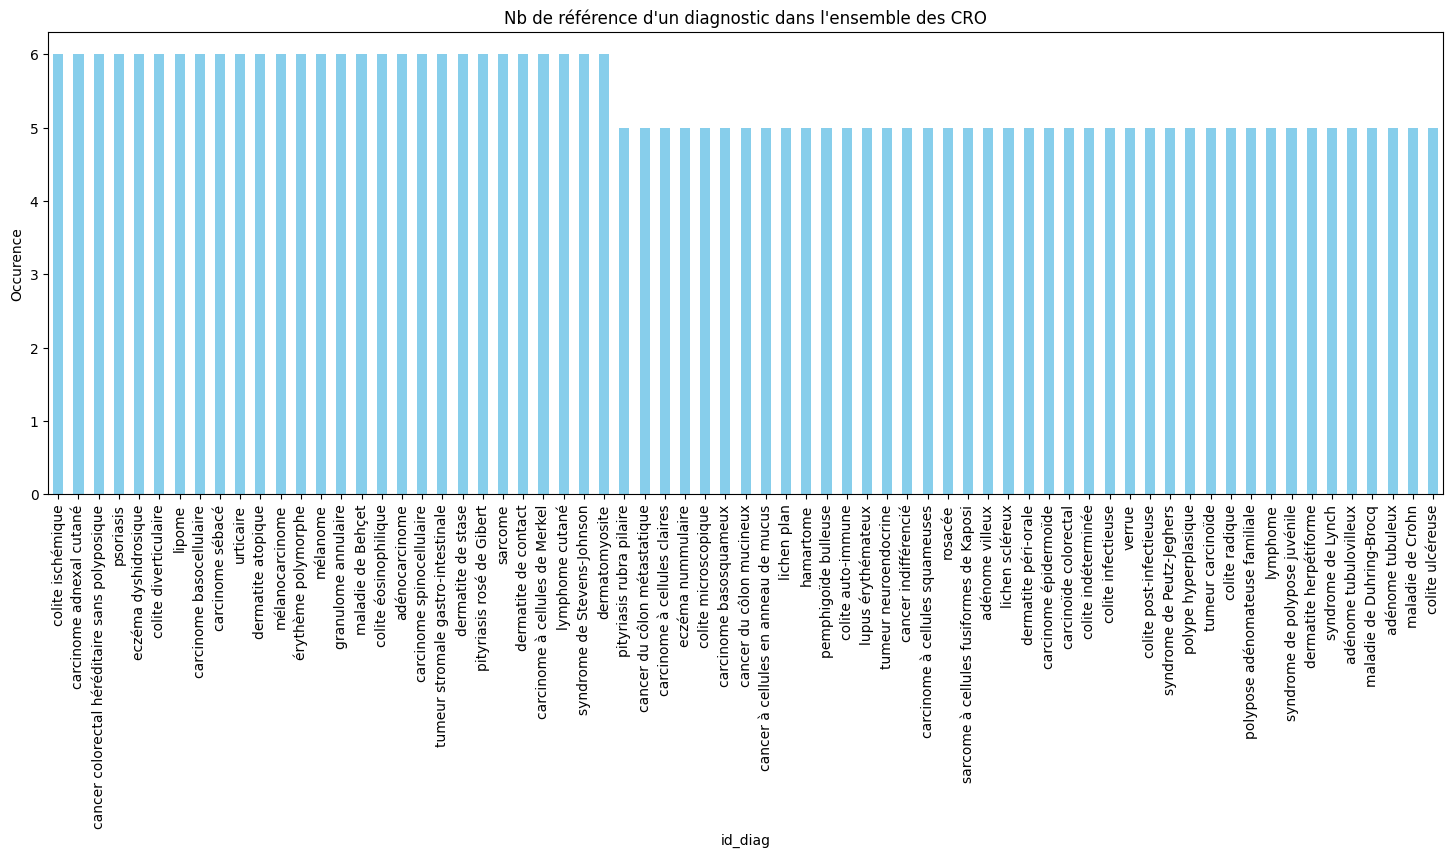

In [28]:
value_counts_bis_bis = CRO_valid_fusion['diagnostic'].value_counts()

plt.figure(figsize=(18, 6))
value_counts_bis_bis.plot(kind='bar', color='skyblue')
plt.title("Nb de référence d'un diagnostic dans l'ensemble des CRO")
plt.xlabel('id_diag')
plt.ylabel('Occurence')

In [29]:
# Mise à niveau du dataframe pour correspondre à la limite sélectionnée par diag

nb_lignes_par_classe = ref

grouped_CRO_valid = CRO_valid_fusion.groupby('diagnostic', group_keys=False)
CRO_valid_eq = grouped_CRO_valid.apply(lambda x: x.sample(nb_lignes_par_classe, random_state=42))
CRO_valid_eq = CRO_valid_eq.reset_index(drop=True)

print('avant réduction:',len(CRO_valid_fusion))
print('après réduction:',len(CRO_valid_eq))

avant réduction: 373
après réduction: 138


In [30]:
print(CRO_valid_eq['diagnostic'].value_counts())

diagnostic
adénocarcinome            2
lymphome cutané           2
pemphigoïde bulleuse      2
mélanome                  2
mélanocarcinome           2
                         ..
dermatite atopique        2
dermatite de contact      2
dermatite de stase        2
dermatite herpétiforme    2
érythème polymorphe       2
Name: count, Length: 69, dtype: int64


## CRO Test

Text(0, 0.5, 'Occurence')

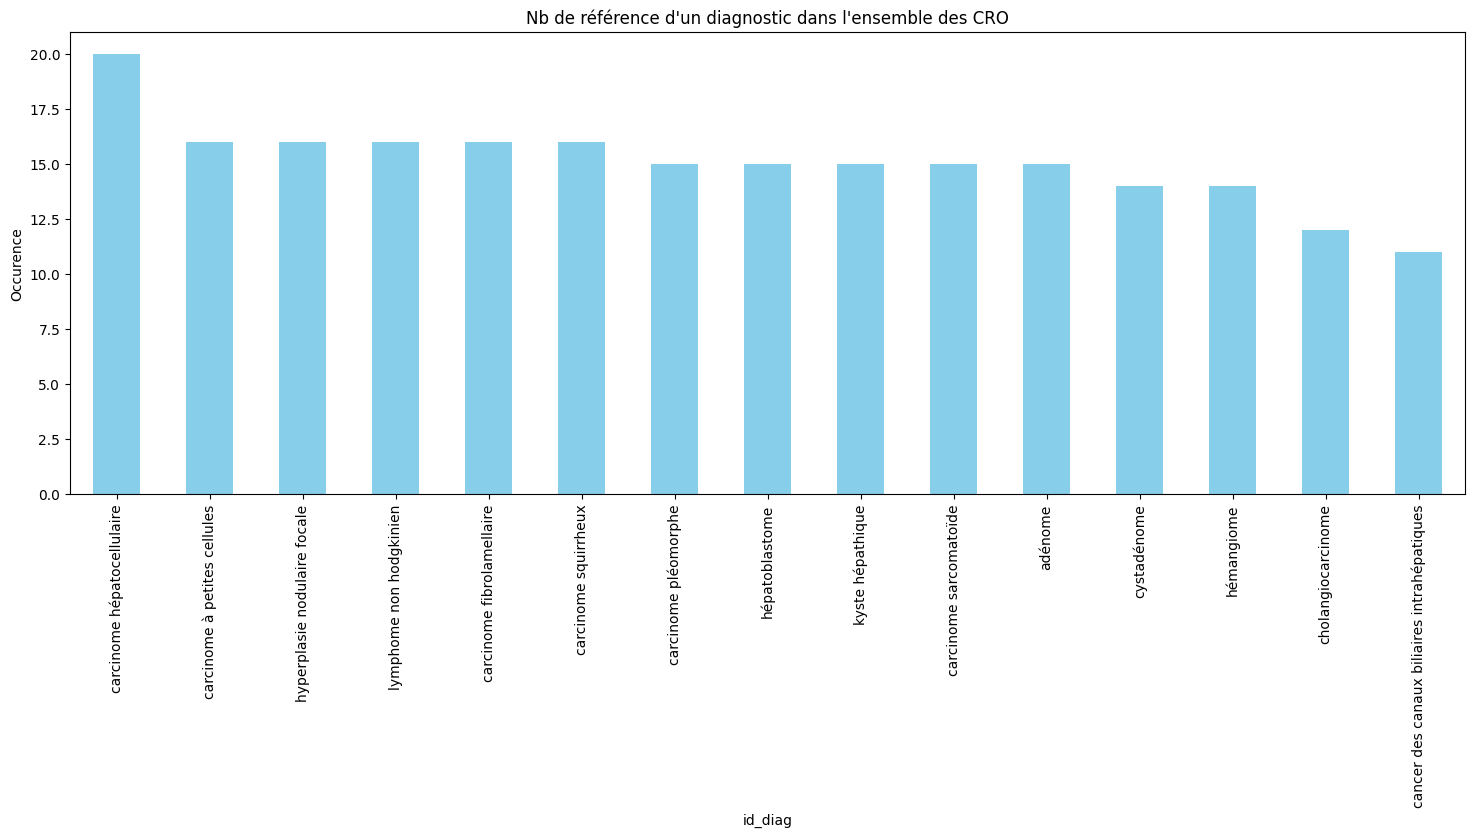

In [31]:
value_counts_test = CRO_test['diagnostic'].value_counts()

plt.figure(figsize=(18, 6))
value_counts_test.plot(kind='bar', color='skyblue')
plt.title("Nb de référence d'un diagnostic dans l'ensemble des CRO")
plt.xlabel('id_diag')
plt.ylabel('Occurence')

In [32]:
# diagnostics qui doivent être augmentés

diagnostics_nb = dict(value_counts_test)
ref = nb_diag_test
# Utilisation d'une compréhension de dictionnaire pour filtrer les clés
diag_inf_test_ref = {cle: valeur for cle, valeur in diagnostics_nb.items() if valeur < ref}
for key, value in diag_inf_test_ref.items():
    print(key, ':', value)

In [33]:
print(f'nb de diag inf à {ref} :', len(diag_inf_test_ref.keys()))

nb de diag inf à 10 : 0


In [34]:
# data augmentation du test si nécessaire

new_CRO_test_list = data_aug_CRO(CRO_test, diag_inf_test_ref, diag, ref)

In [35]:
new_CRO_test = pd.DataFrame(new_CRO_test_list)
new_CRO_test.head()

""


In [36]:
# affichage des diag augmentés

try:
    value_counts_bis_bis = new_CRO_test['diagnostic'].value_counts()

    plt.figure(figsize=(18, 6))
    value_counts_bis_bis.plot(kind='bar', color='skyblue')
    plt.title("Nb de référence d'un diagnostic dans l'ensemble des CRO")
    plt.xlabel('id_diag')
    plt.ylabel('Occurence')
except:
    new_CRO_test = new_CRO_test

In [37]:
#  ajout des nouveaux CRO aux anciens

CRO_test_fusion = pd.concat((CRO_test, new_CRO_test), ignore_index=True)
CRO_test_fusion.head(5)

,id_med,id_diag,nir,CRO,source,operation,address,birthday,organe,diagnostic,cancer,name_patient,name_med
0,48,79,1 1955 01 89175 400 52,"Biopsie de foie réalisée chez Olivier Marie, n...",meta-llama/Llama-2-70b-chat-hf,biopsie,"61, avenue Bazin, 89175 Grondin",27/01/1955,foie,carcinome hépatocellulaire,1,Olivier Marie,Dr Isaac Lefebvre
1,45,76,2 1983 06 73493 810 02,Compte rendu d'histopathologie\nDr David Hardy...,meta-llama/Llama-2-70b-chat-hf,exérèse,"53, avenue Lesage, 73493 Maury",01/06/1983,foie,carcinome à petites cellules,1,Zoé De Oliveira,Dr David Hardy
2,78,72,1 1967 07 79813 483 48,Voici un exemple de compte rendu d'histopathol...,meta-llama/Llama-2-70b-chat-hf,exérèse,"2, rue Océane Guilbert, 79813 Morin",23/07/1967,foie,cystadénome,0,Bernard Charles,Dr Danielle Thomas
3,34,76,1 1945 11 76266 494 47,Biopsie de foie\nRésumé :\nLe présent rapport ...,meta-llama/Llama-2-70b-chat-hf,biopsie,"avenue de Bonnet, 76266 Guyot",13/11/1945,foie,carcinome à petites cellules,1,Thibaut Guibert,Dr Raymond Bourdon
4,94,78,2 1953 06 01925 471 59,Biopsie de foie\nRésumé :\nNous avons procédé ...,meta-llama/Llama-2-70b-chat-hf,biopsie,"320, chemin de Colin, 01925 Lebon-sur-Gautier",11/06/1953,foie,carcinome pléomorphe,1,Susan Masson,Dr Émilie Roy


In [38]:
print(len(new_CRO_test))
print(len(CRO_test))
print(len(new_CRO_test) + len(CRO_test))
print(len(CRO_test_fusion))

0
226
226
226


Text(0, 0.5, 'Occurence')

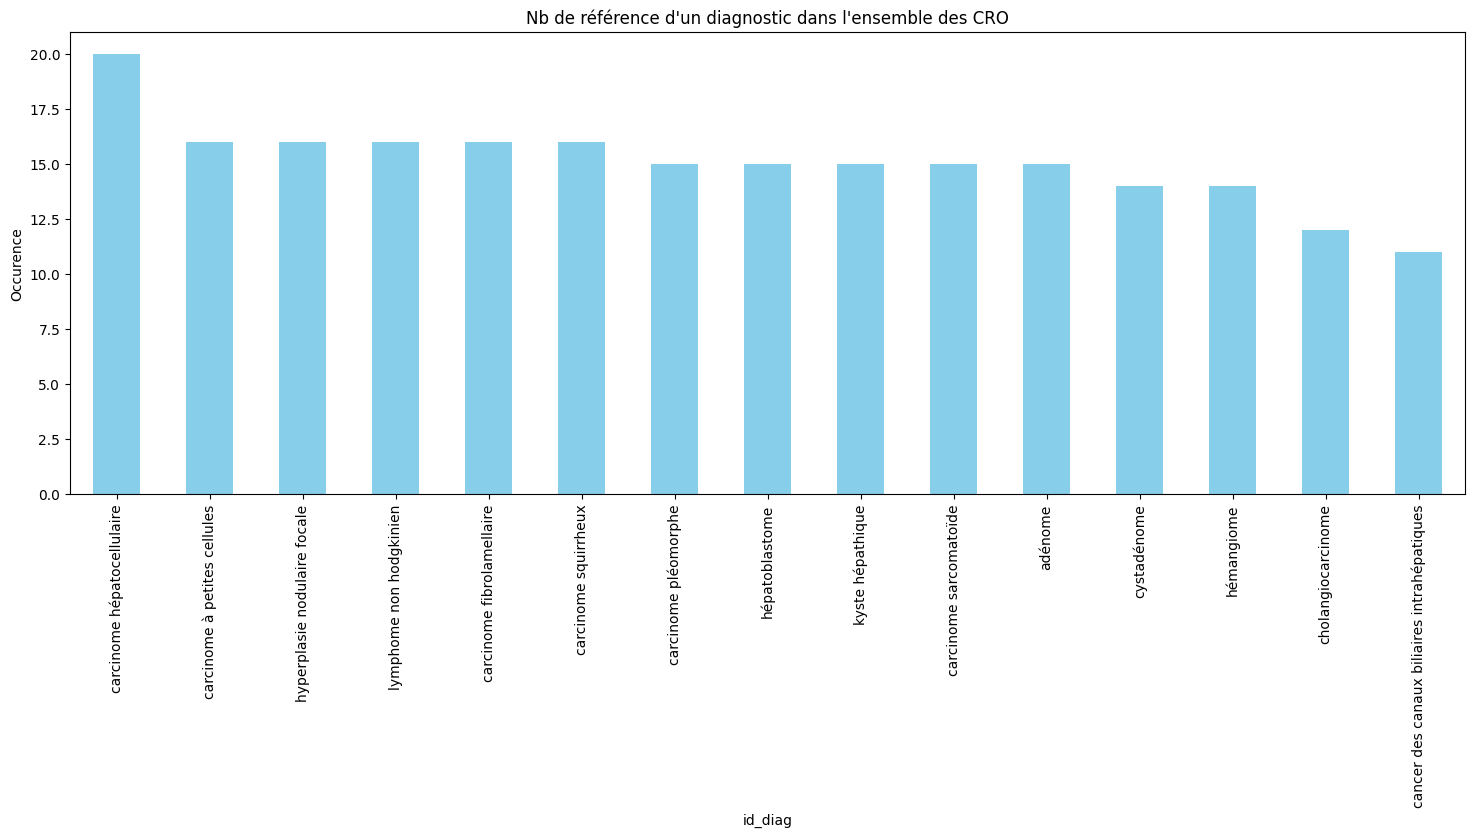

In [39]:
value_counts_bis_bis = CRO_test_fusion['diagnostic'].value_counts()

plt.figure(figsize=(18, 6))
value_counts_bis_bis.plot(kind='bar', color='skyblue')
plt.title("Nb de référence d'un diagnostic dans l'ensemble des CRO")
plt.xlabel('id_diag')
plt.ylabel('Occurence')

In [40]:
# Mise à niveau du dataframe pour correspondre à la limite sélectionnée par diag

nb_lignes_par_classe = ref

grouped_CRO_test = CRO_test_fusion.groupby('diagnostic', group_keys=False)
CRO_test_eq = grouped_CRO_test.apply(lambda x: x.sample(nb_lignes_par_classe, random_state=42))
CRO_test_eq = CRO_test_eq.reset_index(drop=True)

print('avant réduction:',len(CRO_test_fusion))
print('après réduction:',len(CRO_test_eq))

avant réduction: 226
après réduction: 150


In [41]:
print(CRO_test_eq['diagnostic'].value_counts())

diagnostic
adénome                                        10
cancer des canaux biliaires intrahépatiques    10
carcinome fibrolamellaire                      10
carcinome hépatocellulaire                     10
carcinome pléomorphe                           10
carcinome sarcomatoïde                         10
carcinome squirrheux                           10
carcinome à petites cellules                   10
cholangiocarcinome                             10
cystadénome                                    10
hyperplasie nodulaire focale                   10
hémangiome                                     10
hépatoblastome                                 10
kyste hépathique                               10
lymphome non hodgkinien                        10
Name: count, dtype: int64


# Création du fichier JSON

In [42]:
def find_occurrences(texte: str, mot: str) -> list:
    ''' 
    trouve toutes les occurrences d'un mot/phrase en renvoyant les index de début
    - entrée : - texte (str) => texte dans lequel le mot doit être recherché
               - mot (str) => mot recherché dans le texte
    - sortie : list de tous les index de début de localisation dans le texte
    '''
    occurrences = []
    index = -1
    while True:
        # trouve toutes les occurences d'un mot dans le texte jusqu'à la fin
        index = texte.find(mot, index + 1)
        if index == -1:
            break

        index_fin = index + len(mot)

        # vérifie par quoi se termine le mot pour éviter les mots dérivés du mot recherché
        if texte[index_fin] in [' ', ',', '.', ')', ':']:
            occurrences.append(index)
        else:
            print("mot suivi d'une lettre", mot, '\n', texte[index:])

        if -1 in occurrences:
            raise
    return occurrences

def normalisation_texte(texte: str): 
    '''
    mise en minuscule et suppression des retours à la ligne \n.
    '''   
    texte_normalise = texte.replace('\n', ' ')

    return texte_normalise

In [43]:
def csv_to_json(df: pd.DataFrame, file_json : Path) -> str:
    '''
    Génération d'un fichier JSON qui rassemble le texte, les index de début et de fin de chaque mot associé à leur label
    - entrées : - df (pd.DataFrame): dataframe ressemblant le texte et l'ensemble des mots ou groupes de mots recherchés dans le texte.
                - file_json (str): adresse de lecture et de d'enregistrement du fichier JSON
    - sortie : un fichier JSON
    '''
    df_to_json = []

    for i in range(0, len(df)):
        # variables qui comptent le nb de fois qu'une valeur est trouvé dans le texte
        compteur_date = 0
        compteur_diag = 0
        compteur_loc = 0
        compteur_per = 0
        compteur_med = 0

        list_ner = []
        dict_ner = {'entities': []}
        text = normalisation_texte(df.CRO[i])

        # ajout du texte au dictionnaire
        list_ner.append(text)

        # recherche les occurrences des diagnostics
        diag = df.diagnostic[i].lower()
        diag_index = find_occurrences(text.lower(), diag.lower())

        for k in diag_index:
            end = k + len(diag) 
            compteur_diag += 1       
            dict_ner['entities'].append([k, end, 'DIAG'])
        
        # recherche les occurrences des anatomopathologistes
        med = df.name_med[i].lower()
        med_index = find_occurrences(text.lower(), med.lower())

        for k in med_index:
            end = k + len(med) 
            compteur_med += 1       
            dict_ner['entities'].append([k, end, 'PER'])
        
        # recherche les occurrences des patients
        nom_patient = df.name_patient[i].lower()
        name_index = find_occurrences(text.lower(), nom_patient.lower())

        for k in name_index:
            end = k + len(nom_patient)  
            compteur_per += 1      
            dict_ner['entities'].append([k, end, 'PER'])       

        # recherche les occurrences d'une adresse' (sous toutes leurs formes)
        adresse = df.address[i].lower()
        adresse_index = find_occurrences(text.lower(), adresse.lower())

        for k in adresse_index:
            end = k + len(adresse) 
            compteur_loc += 1       
            dict_ner['entities'].append([k, end, 'LOC'])
        
        # recherche les occurences des dates 
        birthday = df.birthday[i].lower()
        birthday_index = find_occurrences(text.lower(), birthday.lower())

        for k in birthday_index:
            end = k + len(birthday)  
            compteur_date += 1      
            dict_ner['entities'].append([k, end, 'DATE'])
        
        # chaque label doit apparaitre au moins une fois dans le texte
        if compteur_date >= 1 and compteur_diag >= 1 and compteur_loc >= 1 and compteur_per >= 1 and compteur_med >=1:
            print("Les conditions sont satisfaites.")
        else:
            print("Les conditions ne sont pas satisfaites. Il manque:")
            if compteur_date == 0:
                print(birthday)
            if compteur_diag == 0:
                print(diag)
            if compteur_loc == 0:
                print(adresse)
            if compteur_med == 0:
                print(med)
            if compteur_per == 0:
                print(nom_patient)
            print("Dans le CRO à l'index ", i, df.CRO[i])

        # ajout les différents index de début et de fin au dictionnaire
        dict_ner['entities'] = sorted(dict_ner['entities'], key=lambda x: x[2])
        list_ner.append(dict_ner)              
        df_to_json.append(list_ner)

    # ouverture du fichier JSON
    to_json = json.dumps(df_to_json, ensure_ascii=False)

    with open(file_json, 'w', encoding="utf-8") as fichier:
        # écriture du fichier JSON, ajout si existe déjà !
        fichier.write(to_json)
    return len(df_to_json)

In [44]:
train_data = CRO_train_eq.sample(n=len(CRO_train_eq), ignore_index=True, random_state=42)
valid_data = CRO_valid_eq.sample(n=len(CRO_valid_eq), ignore_index=True, random_state=42)
test_data = CRO_test_eq.sample(n=len(CRO_test_eq), ignore_index=True, random_state=42)


print('génération du fichier json train')
taille_json_train = csv_to_json(train_data, '../generate_model/assets/train.json')
print(f'La data train possède {len(train_data)}, le JSON train contient {taille_json_train} entrées.')

print('génération du fichier json valid')
taille_json_valid = csv_to_json(valid_data, '../generate_model/assets/dev.json')
print(f'La data valid possède {len(valid_data)}, le JSON valid contient {taille_json_valid} entrées.')

print('génération du fichier json test')
taille_json_test = csv_to_json(test_data, '../generate_model/assets/test.json')
print(f'La data test possède {len(test_data)}, le JSON test contient {taille_json_test} entrées.')

génération du fichier json train
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les condit


Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les conditions sont satisfaites.
Les condi

In [45]:
def pourcentage_ressemblance(liste1, liste2):
    # Convertir les listes en ensembles pour éliminer les doublons
    ensemble1 = set(liste1)
    ensemble2 = set(liste2)

    # Calculer le nombre d'éléments communs
    elements_communs = len(ensemble1.intersection(ensemble2))

    # Calculer le pourcentage de ressemblance
    pourcentage_ressemblance = (elements_communs / len(ensemble1.union(ensemble2))) * 100

    return round(pourcentage_ressemblance, 2)

In [46]:
resultat = pourcentage_ressemblance(train_data.nir.unique().tolist(), valid_data.nir.unique().tolist())
print(f"Le pourcentage de patients à la fois dans le train et le valid est de:\n {resultat}%")


Le pourcentage de patients à la fois dans le train et le valid est de:
 93.75%


In [47]:
resultat = pourcentage_ressemblance(train_data.id_med.unique().tolist(), valid_data.id_med.unique().tolist())
print(f"Le pourcentage d'anatomopathologistes à la fois dans le train et le valid est de:\n {resultat}%")

Le pourcentage d'anatomopathologistes à la fois dans le train et le valid est de:
 95.83%
